# Implementing DeViSE: A Deep Visual-Semantic Embedding Model in Pytorch-Lightning
https://papers.nips.cc/paper/5204-devise-a-deep-visual-semantic-embedding-model.pdf

In [1]:
from pathlib import Path
import os
import subprocess
import pickle
import shutil
import json,re
import pandas as pd
import numpy as np
import random
import zipfile
from PIL import Image
import nmslib
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch
from torch import nn
from torchvision.utils import make_grid
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import fasttext as ft
from gensim.models.wrappers import FastText
%matplotlib inline

In [2]:
pl.__version__

'0.9.0'

## LightningDataModules

In [3]:
# Util functions
def download_data(data_path):
    CALTECH256_PATH = data_path/"caltech-256"
    CALTECH256_FILE_PATH = CALTECH256_PATH/"caltech256.zip"
    Path(data_path).mkdir(parents=True, exist_ok=True)
    Path(CALTECH256_PATH).mkdir(parents=True, exist_ok=True)
    if not CALTECH256_FILE_PATH.is_file():
        # Use kaggle cli: https://github.com/Kaggle/kaggle-api or download it manually here: https://www.kaggle.com/jessicali9530/caltech256
        os.system('kaggle datasets download -d jessicali9530/caltech256 -p '+ str(CALTECH256_PATH))
        with zipfile.ZipFile(CALTECH256_FILE_PATH, 'r') as z:
            z.extractall(CALTECH256_PATH)
    else:
        print("The dataset already exists")
            
def download_ft_model(data_path):
    FASTTEXT_PATH = data_path/"fasttext_vectors"
    ft_model_path = FASTTEXT_PATH/"cc.en.300.bin"
    Path(data_path).mkdir(parents=True, exist_ok=True)
    Path(FASTTEXT_PATH).mkdir(parents=True, exist_ok=True)
    
    from fasttext.util import download_model
    if not ft_model_path.is_file():
        print("Downloading the word vectors")
        download_model('en', if_exists='ignore')
        shutil.move("cc.en.300.bin", ft_model_path)
        shutil.move("cc.en.300.bin.gz", FASTTEXT_PATH/"cc.en.300.bin.gz")
    else:
        print("Word vectors are already downloaded")

class DeviseDataset(Dataset):
    def __init__(self, images, vecs, transform=None):
        self.images = images
        self.vecs = vecs
        self.transform = transform
        
    def __len__(self):
        return len(self.images)    
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_vec = self.vecs[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_vec
    
def load_dataset(data_path):
    FASTTEXT_PATH = data_path/"fasttext_vectors"
    ft_vecs = ft.load_model(str(FASTTEXT_PATH/'cc.en.300.bin'))
    ft_words = ft_vecs.get_words(include_freq=True)
    ft_word_dict = {k:v for k,v in zip(*ft_words)}
    ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])
    lc_vec_d = {w.lower(): ft_vecs.get_word_vector(w) for w in ft_words[-1000000:]}
    
    test_classes = ["bear","piano","laptop","syringe","tomato","calculator","rifle","dog","floppy","octopus"]
    classes = []
    train_images = []
    train_img_vecs = []
    test_images = []
    test_img_vecs = []
    dataset_path = data_path/"caltech-256"/"256_ObjectCategories"
    for class_name in dataset_path.iterdir():
        c = class_name.name.rpartition(".")[-1]
        if c in lc_vec_d:
            class_images = list(class_name.iterdir())
            if c in test_classes:
                test_images += class_images
                test_img_vecs += [lc_vec_d[c]]*len(class_images)
            else:
                classes.append(c)
                train_images += class_images
                train_img_vecs += [lc_vec_d[c]]*len(class_images)
    train_img_vecs = np.stack(train_img_vecs)
    test_img_vecs  = np.stack(test_img_vecs)
    train_img_vecs.shape,test_img_vecs.shape
    
    split=int(len(train_images)*0.75)
    grouped = list(zip(train_images, train_img_vecs)) 
    random.shuffle(grouped) 
    train_images, train_img_vecs = zip(*grouped)
    train_images,valid_images = train_images[:split],train_images[split:]
    train_vecs,  valid_vecs   = train_img_vecs[:split],train_img_vecs[split:]
    
    transform  = transforms.Compose([transforms.Resize(size=(200,200)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    
    train_dataset = DeviseDataset(train_images,train_vecs,transform)
    valid_dataset = DeviseDataset(valid_images,valid_vecs,transform)
    test_dataset = DeviseDataset(test_images,valid_vecs,transform)
    return train_dataset, valid_dataset, test_dataset, ft_vecs, transform

In [4]:
# Defining DataModule
class DeViSEDataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str = Path("./data"), batch_size: int = 64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
    def prepare_data(self):
        download_data(self.data_dir)
        download_ft_model(self.data_dir)
   
    def setup(self):
        self.train_dataset, self.valid_dataset, self.test_dataset, self.ft_vecs, self.transform = load_dataset(self.data_dir)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=2*self.batch_size, shuffle=False, num_workers=4, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=2*self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    def show_sample(self, img, target, invert=True):
        img = self.denorm(img).clamp(0,1)
        if invert:
            plt.imshow(1 - img.permute((1, 2, 0)))
        else:
            plt.imshow(img.permute(1, 2, 0))
    
    def show_batch(self, dl):
        for images, labels in dl:
            fig, ax = plt.subplots(figsize=(16, 8))
            ax.set_xticks([]); ax.set_yticks([])
            data = self.denorm(images).clamp(0,1)
            ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
            break
            
    @staticmethod
    def denorm(img,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        return img*torch.Tensor(std).unsqueeze(1).unsqueeze(1)+torch.Tensor(mean).unsqueeze(1).unsqueeze(1)
    

In [5]:
# it’s best to process the data before passing it to the model
dm = DeViSEDataModule()
dm.prepare_data()
dm.setup()

The dataset already exists
Word vectors are already downloaded


### Showing some samples

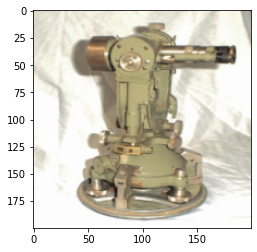

In [6]:
dm.show_sample(*dm.train_dataset[0], invert=False)

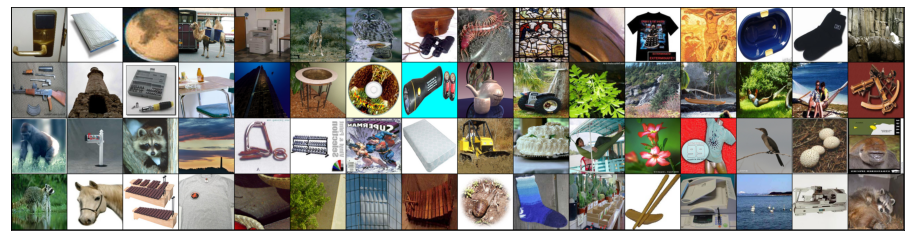

In [7]:
dm.show_batch(dm.train_dataloader())

## Defining the LightningModule

In [9]:
class DeViSE(pl.LightningModule):
    def __init__(self, lr = 3e-3):
        super().__init__()
        
        self.lr = lr
        
        self.save_hyperparameters()
        
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(nn.Flatten(),
                                       nn.Dropout(p=0.25),
                                       nn.Linear(in_features=num_ftrs,out_features=num_ftrs//2),
                                       nn.ReLU(inplace=True),
                                       nn.BatchNorm1d(num_ftrs//2),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(num_ftrs//2,300)) 
        for param in list(self.parameters())[:-8]:
            param.requires_grad = False

    def forward(self, x):
        return self.network(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.lr)
    
    def training_step(self, batch, batch_idx):
        images, targets = batch 
        out = self(images)                      
        loss = 1 - F.cosine_similarity(out,targets).mean()
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, on_epoch=True)
        return result
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch 
        out = self(images)
        loss = 1 - F.cosine_similarity(out,targets).mean()
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('avg_val_loss', loss)
        return result    
    
    @torch.no_grad()
    def predict_dl_batch(self, dl):
        batch_probs = []
        self.eval()
        for xb, _ in tqdm(dl):
            pred_wv = self(xb.to(self.device))
            batch_probs.append(pred_wv.cpu().detach())
        batch_probs = torch.cat(batch_probs)
        return batch_probs.numpy()
    
    @staticmethod
    def create_index(a):
        index = nmslib.init(space='angulardist')
        index.addDataPointBatch(a)
        index.createIndex()
        return index
    
    @staticmethod
    def get_knns(index, vecs):
         return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))
        
    @staticmethod
    def get_knn(index, vec): return index.knnQuery(vec, k=10)
    
    @staticmethod
    def show_preds(idxs, dm, dset="valid"):
        if dset == "valid":
            dataset = dm.valid_dataset
            images = dm.valid_dataset.images
        elif dset == "test":
            dataset = dm.test_dataset
            images = dm.test_datasets.images
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
        for ax,img_idx in zip(axes.flatten(),idxs[:9]):
            p=Path(images[img_idx])
            data = dm.denorm(dataset[img_idx][0]).clamp(0,1)
            data = data.permute(1,2,0).numpy()
            ax.imshow(data)
            title = p.parent.name.rpartition(".")[-1]
            ax.set_title(title)
            ax.axis("off")
            
    def keyword_search(self, dm, keyword, dset="valid"):
        if dset == "valid":
            if not hasattr(self, "predwv_val"):
                print("Computing the word vectors of validation images. It's done just once!")
                self.predwv_val = self.predict_dl_batch(dm.val_dataloader())
            predwv = self.predwv_val
        elif dset == "test":
            if not hasattr(self, "predwv_test"):
                self.predwv_test = self.predict_dl_batch(dm.test_dataloader())
            predwv = self.predwv_test
        else:
            raise Exception("Dataset can be valid or test!")
        
        nn_predwv = self.create_index(predwv)    
        vec = dm.ft_vecs.get_word_vector(keyword)
        idxs,dists = self.get_knn(nn_predwv, vec)
        self.show_preds(idxs, dm)
    
    def reverse_search(self, file_path, dm, dset="valid"):
        img=Image.open(file_path)
        img=img.resize(size=(200,200))
        transform  = dm.transform
        
        if dset == "valid":
            if not hasattr(self, "predwv_val"):
                self.predwv_val = self.predict_dl_batch(dm.val_dataloader())
            predwv = self.predwv_val
        elif dset == "test":
            if not hasattr(self, "predwv_test"):
                self.predwv_test = self.predict_dl_batch(dm.test_dataloader())
            predwv = self.predwv_test
        pred_img=self(transform(img).unsqueeze(0).to(self.device))
        nn_predwv = self.create_index(predwv)
        idxs,dists = self.get_knn(nn_predwv, pred_img.cpu().detach().numpy())
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
        title = "Query Image"
        ax.set_title(title)
        ax.axis("off")
        ax.imshow(img)
        self.show_preds(idxs, dm=dm, dset=dset)

## Training

In [10]:
from pytorch_lightning import Trainer
trainer = Trainer(gpus=1, max_epochs=3)
model = DeViSE()
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/saeedghorbani/anaconda3/envs/pl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name    | Type   | Params
-----------------------------------
0 | network | ResNet | 11 M  


Saving latest checkpoint..


1

## Let's try finding automatically a good learning rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | network | ResNet | 11 M  


Saving latest checkpoint..
<ipython-input-11-f1890fb8e124>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


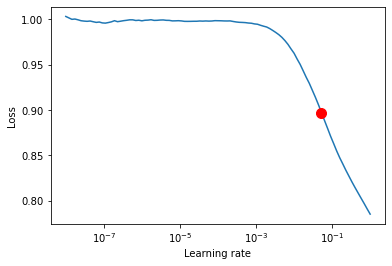

In [11]:
model = DeViSE()
trainer = Trainer(gpus=1)
lr_finder = trainer.lr_find(model, dm)

fig = lr_finder.plot(suggest=True)
fig.show()

In [13]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model = DeViSE(lr = new_lr)
trainer = Trainer(gpus=1, max_epochs=3)
# Fit model
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | network | ResNet | 11 M  


Saving latest checkpoint..


1

## Trying mixed-precision 

In [15]:
trainer = Trainer(gpus=1, max_epochs=3, precision=16)
model = DeViSE()
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name    | Type   | Params
-----------------------------------
0 | network | ResNet | 11 M  


Saving latest checkpoint..


1

In [16]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 2150538), started 4:39:30 ago. (Use '!kill 2150538' to kill it.)

## Keyword Search

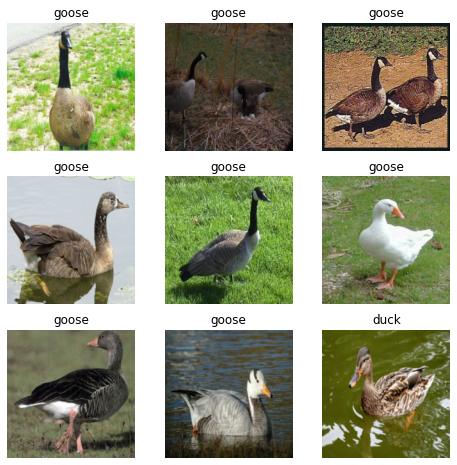

In [17]:
model.keyword_search(dm, "goose")

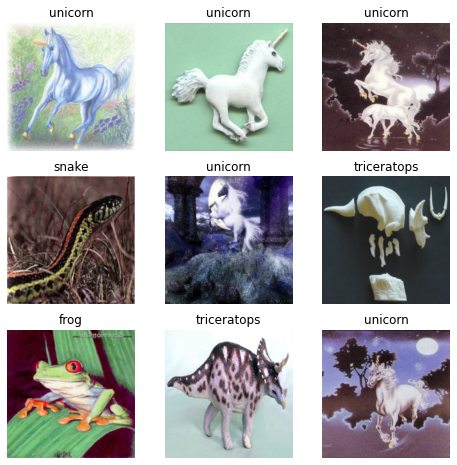

In [18]:
model.keyword_search(dm, "dragon")

## Image Reverse Search

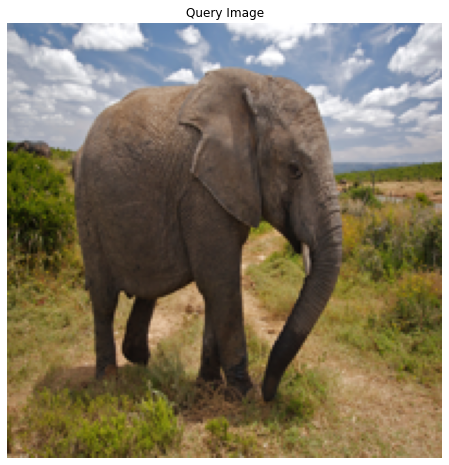

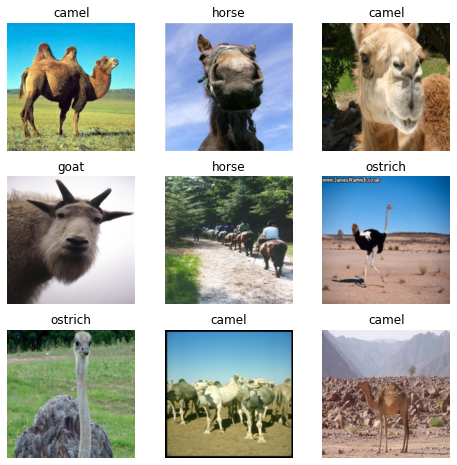

In [19]:
file_path = "elephant.png"
model.reverse_search(file_path, dm)